<a href="https://colab.research.google.com/github/bghata/Energy-Consumption-Analysis-R-/blob/master/Wifi_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

In [0]:
%%R
install.packages("readr")

In [0]:
%%R
library(readr)

**Loading the libraries**

In [0]:
%%R
pacman::p_load(DBI, data.table, ggplot2, dplyr, 
               lattice, caret, plotly, lubridate,
               zoo, forecast, ggfortify, stats, tufte, 
               ggthemes, rapportools, fpp2, fma, expsmooth,
               gbm, scatterplot3d, reshape2, Hmisc, rio, 
               colorspace,grid, VIM, class, sp, spData, spdep, 
               randomForest, magrittr, Matrix, learningr)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

**Loading the data set**

In [0]:
%%R
dataTraining = read_csv('/content/gdrive/My Drive/Colab Notebooks/Wifi_Data_Files/trainingData.csv')
dataValidation = read_csv('/content/gdrive/My Drive/Colab Notebooks/Wifi_Data_Files/validationData.csv')

**Replace na with -110 on dataTraining & dataValidation**

In [0]:
%%R
dataTraining[is.na(dataTraining)] = -110
dataValidation[is.na(dataValidation)] = -110

**Detecting outliers**

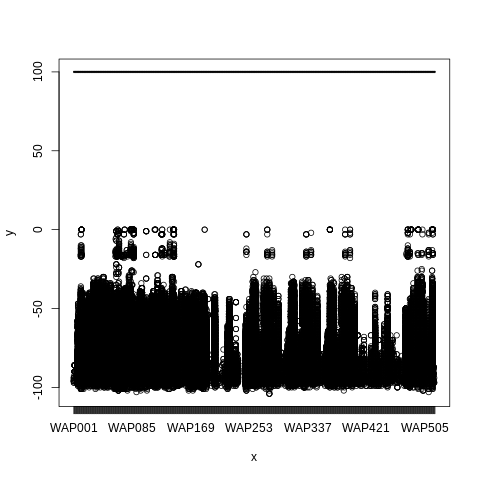

In [58]:
%%R
plot( x = as.factor(rep(colnames(dataTraining)[1:520],nrow(dataTraining))), y = c(t(dataTraining[,1:520])))

**Replacing outliers between (0 and -40) with -50**

In [0]:
%%R
for (i in c(1:nrow(dataTraining))) {
  sapply(dataTraining[i, 1:520], function(x) {if (max(x) > -40)   replace(x, x > -40, -50)})
}

**Converting data type from dataTraining & dataValidation**

In [0]:
%%R
dataTraining$LONGITUDE <- as.numeric(dataTraining$LONGITUDE)
dataTraining$LATITUDE <- as.numeric(dataTraining$LATITUDE)
dataTraining$FLOOR <- as.factor(dataTraining$FLOOR)
dataTraining$BUILDINGID <- as.factor(dataTraining$BUILDINGID)

dataValidation$LONGITUDE <- as.numeric(dataValidation$LONGITUDE)
dataValidation$LATITUDE <- as.numeric(dataValidation$LATITUDE)
dataValidation$FLOOR <- as.factor(dataValidation$FLOOR)
dataValidation$BUILDINGID <- as.factor(dataValidation$BUILDINGID)

**Removing WAPs where na = 100 / from dataTraining**

In [0]:
%%R
dataTraining <- dataTraining[,colSums(is.na(dataTraining))<nrow(dataTraining)]
dataTraining <- dataTraining[rowSums(is.na(dataTraining[ , -c(466:474)]))< (ncol(dataTraining) -9) , ]

**Adding 4 variables (BUILDINGID, FLOOR, LONGITUDE, LATITUDE) to 4 seperate datasets for easier analysis**

**Removing non-related attributes, and creating training data with WAPs and BUILDINGID**

In [0]:
%%R
trainData_building = dataTraining
trainData_building$FLOOR = NULL
trainData_building$LONGITUDE = NULL
trainData_building$LATITUDE = NULL
trainData_building$PHONEID = NULL
trainData_building$USERID = NULL
trainData_building$RELATIVEPOSITION = NULL
trainData_building$SPACEID = NULL
trainData_building$TIMESTAMP = NULL

validData_building = dataValidation
validData_building$FLOOR = NULL
validData_building$LONGITUDE = NULL
validData_building$LATITUDE = NULL
validData_building$PHONEID = NULL
validData_building$USERID = NULL
validData_building$RELATIVEPOSITION = NULL
validData_building$SPACEID = NULL
validData_building$TIMESTAMP = NULL

new_valid_building <- validData_building[,match(colnames(trainData_building), colnames(validData_building))]

**Removing non-related attributes, and creating training data with WAPs and FLOOR**

In [0]:
%%R
trainData_floor = dataTraining
trainData_floor$BUILDINGID = NULL
trainData_floor$LONGITUDE = NULL
trainData_floor$LATITUDE = NULL
trainData_floor$PHONEID = NULL
trainData_floor$USERID = NULL
trainData_floor$RELATIVEPOSITION = NULL
trainData_floor$SPACEID = NULL
trainData_floor$TIMESTAMP = NULL

validData_floor = dataValidation
validData_floor$BUILDINGID = NULL
validData_floor$LONGITUDE = NULL
validData_floor$LATITUDE = NULL
validData_floor$PHONEID = NULL
validData_floor$USERID = NULL
validData_floor$RELATIVEPOSITION = NULL
validData_floor$SPACEID = NULL
validData_floor$TIMESTAMP = NULL

new_valid_floor <- validData_floor[,match(colnames(trainData_floor), colnames(validData_floor))]

**Removing non-related attributes, and creating training data with WAPs and LONGITUDE**

In [0]:
%%R
trainData_longitude = dataTraining
trainData_longitude$BUILDINGID = NULL
trainData_longitude$FLOOR = NULL
trainData_longitude$LATITUDE = NULL
trainData_longitude$PHONEID = NULL
trainData_longitude$USERID = NULL
trainData_longitude$RELATIVEPOSITION = NULL
trainData_longitude$SPACEID = NULL
trainData_longitude$TIMESTAMP = NULL

validData_longitude = dataValidation
validData_longitude$BUILDINGID = NULL
validData_longitude$FLOOR = NULL
validData_longitude$LATITUDE = NULL
validData_longitude$PHONEID = NULL
validData_longitude$USERID = NULL
validData_longitude$RELATIVEPOSITION = NULL
validData_longitude$SPACEID = NULL
validData_longitude$TIMESTAMP = NULL

new_valid_longitude <- validData_longitude[,match(colnames(trainData_longitude), colnames(validData_longitude))]

**Removing non-related attributes, and creating training data with WAPs and LATITUDE**

In [0]:
%%R
trainData_latitude = dataTraining
trainData_latitude$BUILDINGID = NULL
trainData_latitude$FLOOR = NULL
trainData_latitude$LONGITUDE = NULL
trainData_latitude$PHONEID = NULL
trainData_latitude$USERID = NULL
trainData_latitude$RELATIVEPOSITION = NULL
trainData_latitude$SPACEID = NULL
trainData_latitude$TIMESTAMP = NULL

validData_latitude = dataValidation
validData_latitude$BUILDINGID = NULL
validData_latitude$FLOOR = NULL
validData_latitude$LONGITUDE = NULL
validData_latitude$PHONEID = NULL
validData_latitude$USERID = NULL
validData_latitude$RELATIVEPOSITION = NULL
validData_latitude$SPACEID = NULL
validData_latitude$TIMESTAMP = NULL

new_valid_latitude <- validData_latitude[,match(colnames(trainData_latitude), colnames(validData_latitude))]

**Splitting data into trainSet & testSet for each round of running a new model**

**K-NN Model on BUILDING**

In [0]:
%%R
set.seed(123)
trainData1 <- createDataPartition(y = trainData_building$BUILDINGID, p = 0.75, list = FALSE)
trainSet1 <- trainData_building[trainData1,]
testSet1 <- trainData_building[-trainData1,]

**Fit Control / Cross Validation / K-NN model**

In [67]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_building <- train((BUILDINGID ~ .), 
                          data = trainSet1, 
                          method = "knn", 
                          trControl = fitControl, 
                          tuneGrid = expand.grid(k = 5))
knn_fit_building

k-Nearest Neighbors 

14953 samples
  520 predictor
    3 classes: '0', '1', '2' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11962, 11962, 11963, 11962, 11963 
Resampling results:

  Accuracy   Kappa   
  0.9967231  0.994848

Tuning parameter 'k' was held constant at a value of 5


**Testing k-NN model on testSet1**

In [68]:
%%R
knn_Pred_building <- predict(knn_fit_building, newdata = testSet1)
knn_CM_building_tes <- confusionMatrix(knn_Pred_building, testSet1$BUILDINGID)
knn_CM_building_tes

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2
         0 1309    0    0
         1    3 1294    8
         2    0    5 2365

Overall Statistics
                                          
               Accuracy : 0.9968          
                 95% CI : (0.9948, 0.9982)
    No Information Rate : 0.4761          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.995           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9977   0.9962   0.9966
Specificity            1.0000   0.9970   0.9981
Pos Pred Value         1.0000   0.9916   0.9979
Neg Pred Value         0.9992   0.9986   0.9969
Prevalence             0.2632   0.2606   0.4761
Detection Rate         0.2626   0.2596   0.4745
Detection Prevalence   0.2626   0.2618   0.4755
Balanced Accuracy      0.9989

**Testing k-NN model on dataValidation**

In [69]:
%%R
knn_Pred_building_val <- predict(knn_fit_building, newdata = validData_building)
knn_CM_building_val <- confusionMatrix(knn_Pred_building_val, validData_building$BUILDINGID)
knn_CM_building_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2
         0 533   0   0
         1   1 307   5
         2   2   0 263

Overall Statistics
                                          
               Accuracy : 0.9928          
                 95% CI : (0.9859, 0.9969)
    No Information Rate : 0.4824          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9886          
                                          
 Mcnemar's Test P-Value : 0.04601         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2
Sensitivity            0.9944   1.0000   0.9813
Specificity            1.0000   0.9925   0.9976
Pos Pred Value         1.0000   0.9808   0.9925
Neg Pred Value         0.9948   1.0000   0.9941
Prevalence             0.4824   0.2763   0.2412
Detection Rate         0.4797   0.2763   0.2367
Detection Prevalence   0.4797   0.2817   0.2385
Balanced Accuracy      0.9972   0.9963   

**k-NN Model on FLOOR**

In [0]:
%%R
set.seed(123)
trainData2 <- createDataPartition(y = trainData_floor$FLOOR, p = 0.75, list = FALSE)
trainSet2 <- trainData_floor [trainData2,]
testSet2 <- trainData_floor [-trainData2,]

**Fit Control / Cross Validation / K-NN model**

In [71]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_floor <- train((FLOOR ~ .), 
                       data = trainSet2, 
                       method = "knn", 
                       trControl = fitControl, 
                       tuneGrid = expand.grid(k = 5))
knn_fit_floor

k-Nearest Neighbors 

14954 samples
  520 predictor
    5 classes: '0', '1', '2', '3', '4' 

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11962, 11965, 11963, 11962, 11964 
Resampling results:

  Accuracy  Kappa    
  0.958607  0.9464401

Tuning parameter 'k' was held constant at a value of 5


**Testing k-NN model on testSet2**

In [72]:
%%R
knn_Pred_floor <- predict(knn_fit_floor, newdata = testSet2)
knn_CM_floor_val <- confusionMatrix(knn_Pred_floor, testSet2$FLOOR)
knn_CM_floor_val

Confusion Matrix and Statistics

          Reference
Prediction    0    1    2    3    4
         0 1075   67    2    2    0
         1    6 1169   20    1    0
         2    1   12 1026   13    0
         3   10    2   56 1246    0
         4    0    0    0    0  275

Overall Statistics
                                          
               Accuracy : 0.9615          
                 95% CI : (0.9557, 0.9666)
    No Information Rate : 0.2533          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9501          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9844   0.9352   0.9293   0.9873  1.00000
Specificity            0.9818   0.9928   0.9933   0.9817  1.00000
Pos Pred Value         0.9380   0.9774   0.9753   0.9482  1.00000
Neg Pred Value         0.9956   0.978

**Testing k-NN model on validData_floor**

In [73]:
%%R
knn_Pred_floor_val <- predict(knn_fit_floor, newdata = validData_floor)
knn_CM_floor_val <- confusionMatrix(knn_Pred_floor_val, validData_floor$FLOOR)
knn_CM_floor_val

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3   4
         0 116  68   8   4   2
         1   8 324  13   0   0
         2   6  59 202   7   0
         3   2  11  83 159  15
         4   0   0   0   2  22

Overall Statistics
                                          
               Accuracy : 0.7408          
                 95% CI : (0.7139, 0.7663)
    No Information Rate : 0.4158          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6513          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8788   0.7013   0.6601   0.9244   0.5641
Specificity            0.9162   0.9676   0.9106   0.8818   0.9981
Pos Pred Value         0.5859   0.9391   0.7372   0.5889   0.9167
Neg Pred Value         0.9825   0.8198   0.8757   0.9845   0.9844
P

**k-NN Model on Longitude**

In [0]:
%%R
set.seed(123)
trainData3 <- createDataPartition(y = trainData_longitude$LONGITUDE, p = 0.75, list = FALSE)
trainSet3 <- trainData_longitude [trainData3,]
testSet3 <- trainData_longitude [-trainData3,]

**Fit Control / Cross Validation / K-NN model**

In [75]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_longitude <- train((LONGITUDE ~ .), 
                           data = trainSet3, 
                           method = "knn", 
                           trControl = fitControl, 
                           tuneGrid = expand.grid(k = 5))
knn_fit_longitude

k-Nearest Neighbors 

14955 samples
  520 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11963, 11965, 11964, 11963, 11965 
Resampling results:

  RMSE     Rsquared   MAE     
  10.9136  0.9920967  4.458733

Tuning parameter 'k' was held constant at a value of 5


**Testing k-NN model on testSet3**

In [76]:
%%R
knn_Pred_longitude <- predict(knn_fit_longitude, newdata = testSet3)
postResample(knn_Pred_longitude, testSet3$LONGITUDE)

     RMSE  Rsquared       MAE 
9.0799665 0.9945795 3.8540288 


**Testing k-NN model on validData_longitude**

In [78]:
%%R
knn_Pred_longitude_val <- predict(knn_fit_longitude, newdata = validData_longitude)
postResample(knn_Pred_longitude_val, validData_longitude$LONGITUDE)

      RMSE   Rsquared        MAE 
20.1294736  0.9720978 10.1879940 


**k-NN Model on Latitude**

In [0]:
%%R
set.seed(123)
trainData4 <- createDataPartition(y = trainData_latitude$LATITUDE, p = 0.75, list = FALSE)
trainSet4 <- trainData_latitude [trainData4,]
testSet4 <- trainData_latitude [-trainData4,]

**Fit Control / Cross Validation / K-NN model**

In [80]:
%%R
fitControl <- trainControl(method = "repeatedcv", number = 5, repeats = 1)
knn_fit_latitude <- train((LATITUDE ~ .), 
                          data = trainSet4, 
                          method = "knn", 
                          trControl = fitControl, 
                          tuneGrid = expand.grid(k = 4))
knn_fit_latitude

k-Nearest Neighbors 

14953 samples
  520 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 11963, 11962, 11964, 11962, 11961 
Resampling results:

  RMSE     Rsquared   MAE     
  7.06613  0.9887733  3.226847

Tuning parameter 'k' was held constant at a value of 4


**Testing k-NN model on testSet4**

In [81]:
%%R
knn_Pred_latitude <- predict(knn_fit_latitude, newdata = testSet4)
postResample(knn_Pred_latitude, testSet4$LATITUDE)

     RMSE  Rsquared       MAE 
6.8364082 0.9897574 2.9754925 


**Testing k-NN model on validData_latitude**

In [82]:
%%R
knn_Pred_latitude_val <- predict(knn_fit_latitude, newdata = validData_latitude)
postResample(knn_Pred_latitude_val, validData_latitude$LATITUDE)

      RMSE   Rsquared        MAE 
16.2498909  0.9477929  8.7700491 
